In [36]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

In [38]:
with open('../trained_models/03_oja_sf_gradients/td_gradient_update.p', 'rb') as f:
    td_data = pickle.load(f)

In [39]:
with open('../trained_models/03_oja_sf_gradients/simplif_gradient_update.p', 'rb') as f:
    simplif_data = pickle.load(f)

In [40]:
with open('../trained_models/03_oja_sf_gradients/oja_baseline.p', 'rb') as f:
    oja_data = pickle.load(f)

In [41]:
with open('../trained_models/03_oja_sf_gradients/rnn_baseline.p', 'rb') as f:
    rnn_data = pickle.load(f)

In [42]:
smooth_amt = 10

In [43]:
td_dist = td_data['autodiff_dist']
td_dist['Step'] = np.floor(td_dist['Step']/smooth_amt)*smooth_amt
td_dist['Time'] = td_dist['Step']/configs.dt_to_sec/60.

In [44]:
simplif_dist = simplif_data['autodiff_dist']
simplif_dist['Step'] = np.floor(simplif_dist['Step']/smooth_amt)*smooth_amt
simplif_dist['Time'] = simplif_dist['Step']/configs.dt_to_sec/60.

# Gradient Alignment

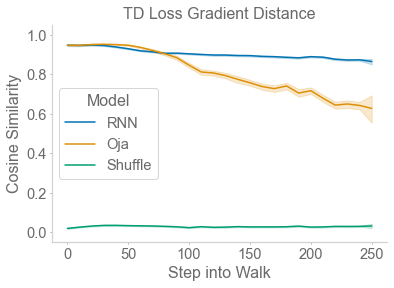

In [45]:
plt.figure()
sns.lineplot(x='Step', y='Distance', hue='Model', data=td_dist)
plt.ylim(-0.05, 1.05)
plt.ylabel('Cosine Similarity')
plt.xlabel('Step into Walk')
plt.title('TD Loss Gradient Distance')
plt.show()

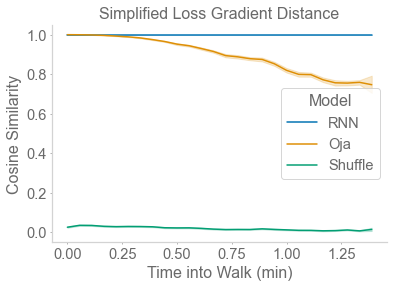

In [46]:
plt.figure()
sns.lineplot(
    x='Time', y='Distance', hue='Model',
    data=simplif_dist
    )
plt.ylim(-0.05, 1.05)
plt.ylabel('Cosine Similarity')
plt.xlabel('Time into Walk (min)')
plt.title('Simplified Loss Gradient Distance')
plt.show()

# Final Test TD Loss

In [47]:
td_losses = []
grad_types = []

td_losses.extend([x.item() for x in td_data['test_losses']])
grad_types.extend(['TD Loss']*len(td_data['test_losses']))
td_losses.extend([x.item() for x in simplif_data['test_losses']])
grad_types.extend(['Simplif. Loss']*len(simplif_data['test_losses']))
td_losses.extend([x for x in rnn_data['test_losses']])
grad_types.extend(['RNN-SF']*len(rnn_data['test_losses']))
td_losses.extend([x for x in oja_data['test_losses']])
grad_types.extend(['RNN-Oja']*len(oja_data['test_losses']))

data = pd.DataFrame({'TD Loss': td_losses, 'Gradient Update': grad_types})

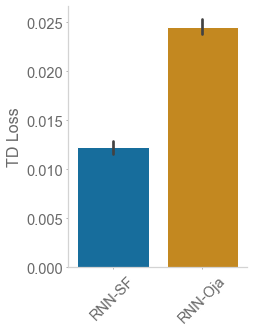

In [48]:
plt.figure(figsize=(6.4*0.5, 4.8))
ax = sns.barplot(
    x='Gradient Update', y='TD Loss',
    data=data
    )
for label in ax.get_xticklabels():
    label.set_rotation(45)
plt.xlabel('')
plt.show()

# Visual Examples of Gradient

In [56]:
data = simplif_data

In [57]:
data['saved_grads'].keys()

dict_keys([97, 98, 99])

In [62]:
key = 99
steps = data['saved_grads'][key]['steps']
bp = data['saved_grads'][key]['bp']
rnn = data['saved_grads'][key]['rnn']
oja = data['saved_grads'][key]['oja']
dset = data['saved_grads'][key]['dset']

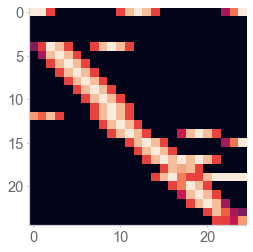

In [71]:
feature_map = dset.feature_maker.feature_map
argsort = np.argsort(np.argmax(feature_map, axis=1))

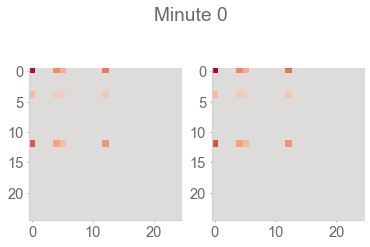

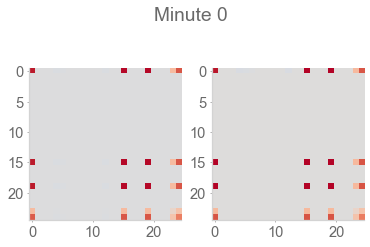

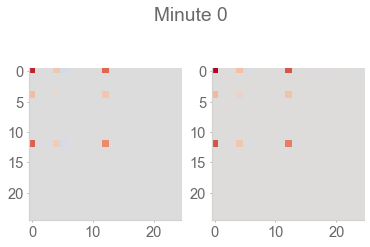

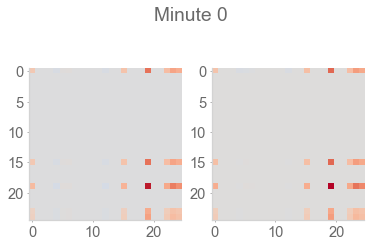

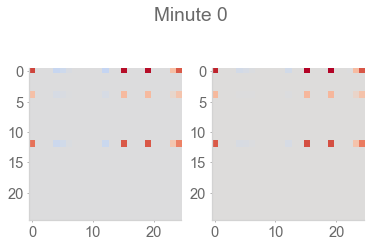

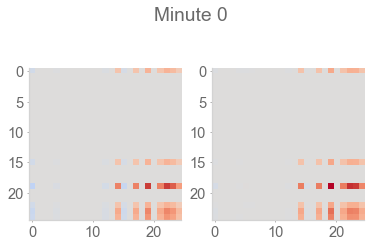

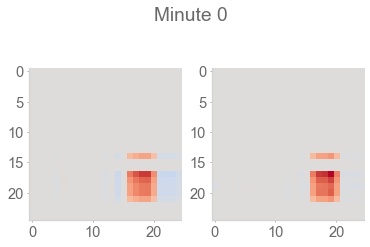

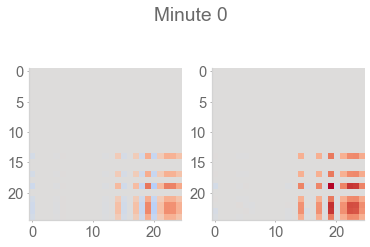

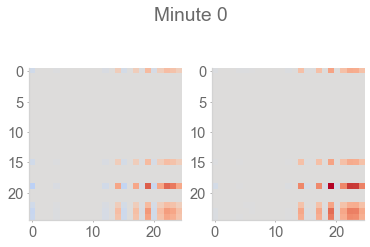

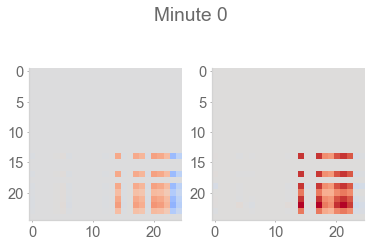

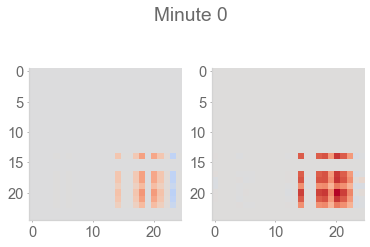

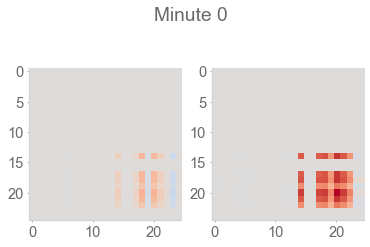

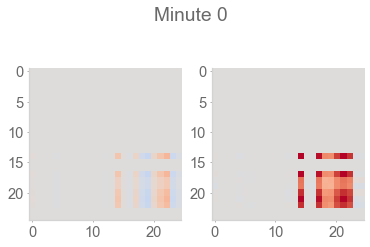

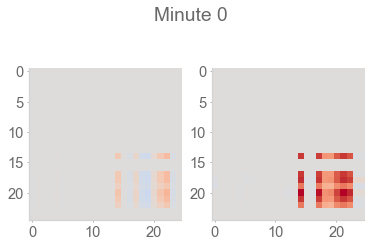

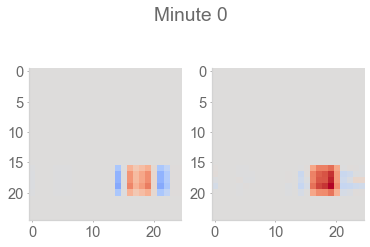

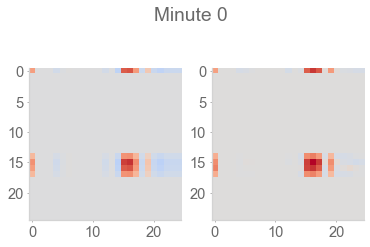

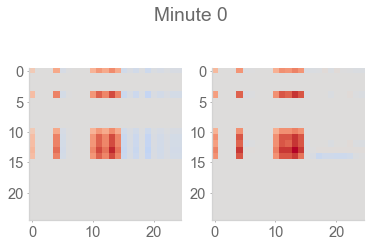

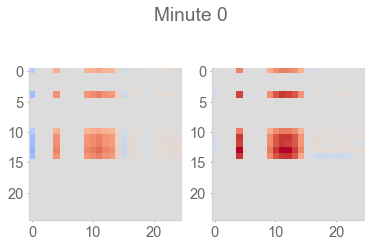

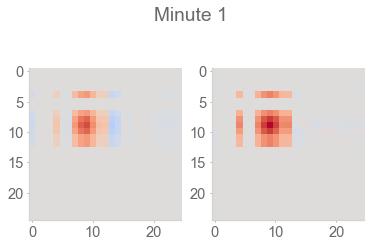

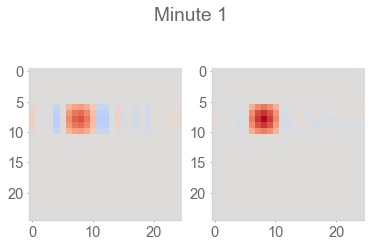

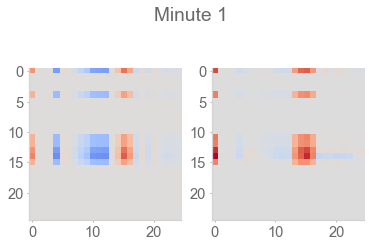

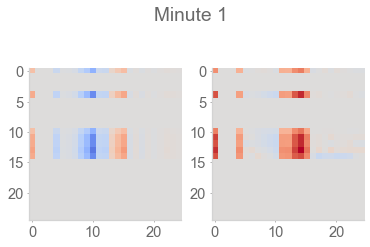

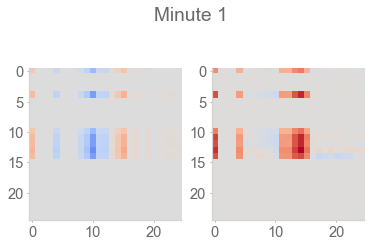

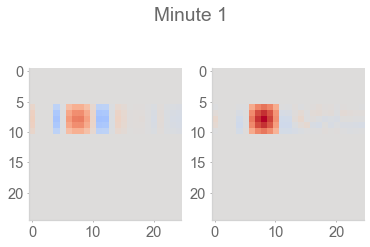

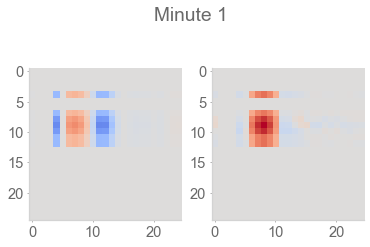

In [90]:
for idx in range(25):
    fig, axs = plt.subplots(1, 2)
    rnn_grad = rnn[idx][argsort][:,argsort]
    oja_grad = oja[idx][argsort][:,argsort]
    c_lim = max(np.abs(rnn_grad).max(), np.abs(oja_grad).max())
    axs[0].imshow(rnn_grad, vmin=-c_lim, vmax=c_lim, cmap='coolwarm')
    axs[1].imshow(oja_grad, vmin=-c_lim, vmax=c_lim, cmap='coolwarm')
    minute = (idx*10)/configs.dt_to_sec/60.
    plt.suptitle(f'Minute {int(minute)}')
    plt.show()
    print("=================")

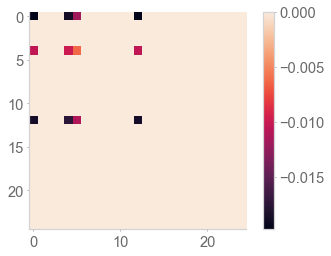

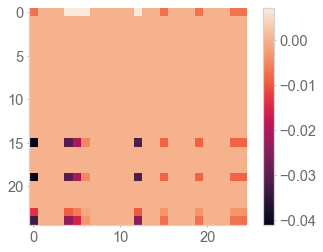

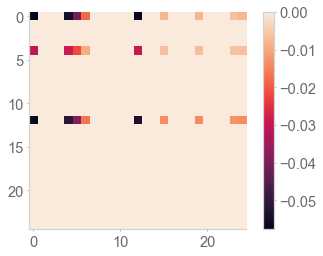

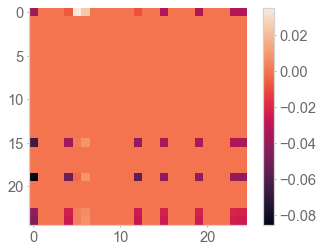

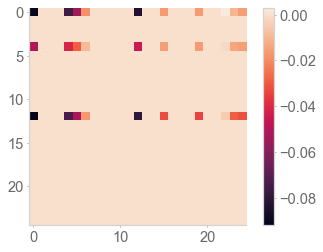

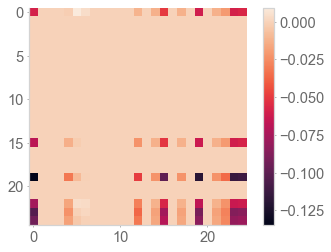

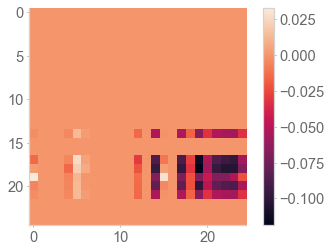

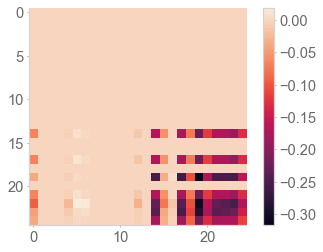

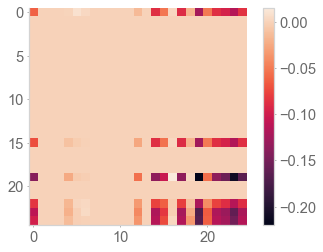

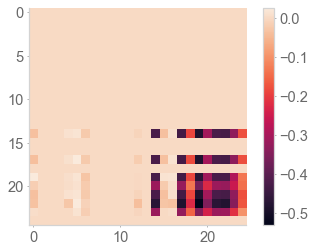

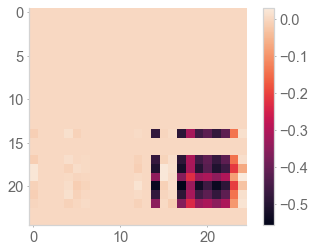

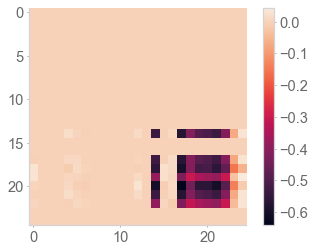

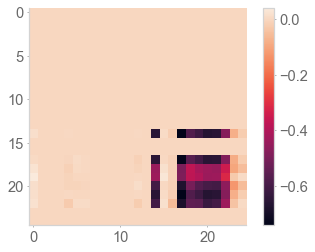

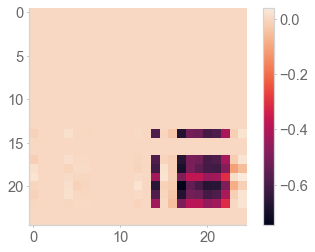

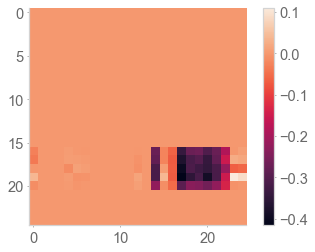

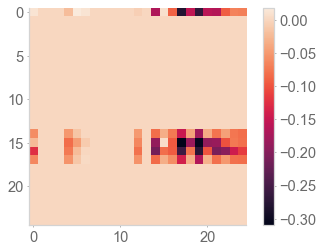

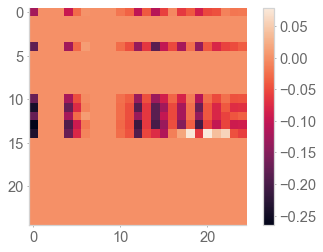

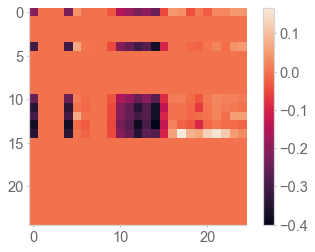

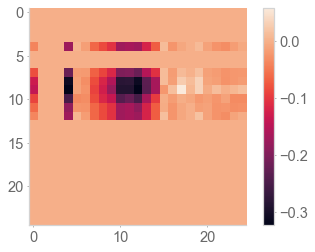

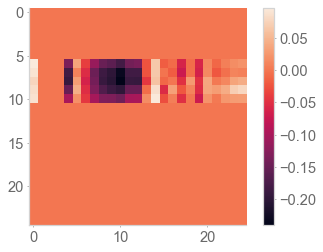

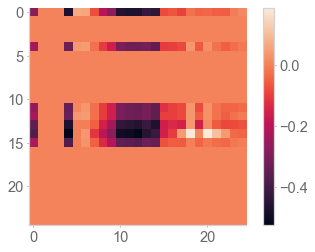

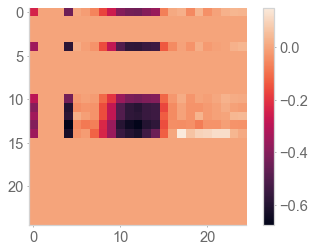

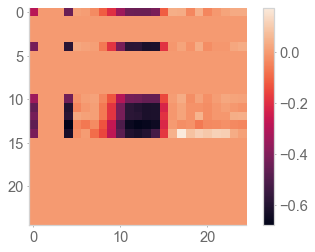

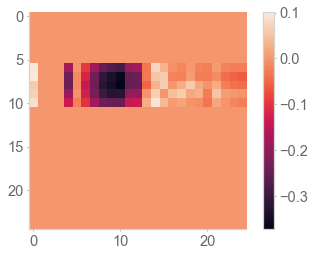

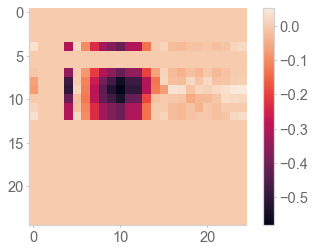

In [76]:
for idx in range(25):
    plt.figure()
    plt.imshow(rnn[idx][argsort][:,argsort])
    plt.colorbar()
    plt.show()
    plt.figure()
    plt.imshow(oja[idx][argsort][:,argsort])
    plt.colorbar()
    plt.show()
    print("=================")